# Autoencoders para Colorear Imagenes en Escalas de Grises
---
**Montar la carpeta de Google Drive y definir constantes para trabajar**

In [ ]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    LOCAL_DIR = './DATOS/'  # carpeta local en maquina virtual
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../DATOS/' # carpeta donde se encuentran los datasets
    LOCAL_DIR = DATOS_DIR


# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Mounted at /content/drive/


**Inclusión de paquetes**

In [ ]:
import numpy as np
import re
import matplotlib.pyplot as plt
import os
import shutil
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import img_to_array
from tqdm import tqdm
from zipfile import ZipFile
from PIL import Image
import glob

**Preparación del Archivo de Datos**

Recupera el archivo comprimido de la carpeta de g-drive y lo descomprime en una carpeta local para hacer más rápido el acceso a las imágenes.

In [ ]:
ZIP_ARCH = 'landscape_color_gray.zip' # archivo comprimido

# Verificar y crear la carpeta de datos local si no existe
if not os.path.exists(LOCAL_DIR):
    os.makedirs(LOCAL_DIR)

# Comprueba la existencia del archivo en la carpeta de destino
if not os.path.exists(os.path.join(LOCAL_DIR, ZIP_ARCH)):
    # Ruta completa del archivo origen
    source_file = os.path.join(DATOS_DIR, ZIP_ARCH)

    shutil.copy(source_file, LOCAL_DIR) # Copiar el archivo a la carpeta local de datos

    # Descomprimir el archivo ZIP
    with ZipFile(os.path.join(LOCAL_DIR, ZIP_ARCH), 'r') as zip_ref:
        zip_ref.extractall(LOCAL_DIR)
        print(f"El archivo {ZIP_ARCH} se ha copiado y descomprimido en {LOCAL_DIR}.")

El archivo landscape_color_gray.zip se ha copiado y descomprimido en /content/Datos/.


In [ ]:
SIZE = 96  # Tamaño de la imagen que será procesada por la red
color_img = []
gray_img = []

ruta_color = 'landscape Images/color/'
ruta_grises = 'landscape Images/gray/'

archivos = glob.glob(DATOS_LOCAL_DIR + ruta_color + '*.jpg')

for ruta_arch in tqdm(archivos):
    # Imagen en color
    img_color = Image.open(ruta_arch)
    img_color = img_color.convert('RGB')  # Convertir a formato RGB si no lo está
    img_color = img_color.resize((SIZE, SIZE))  # Cambiar tamaño
    img_color = np.array(img_color)  # Convertir a arreglo numpy
    img_color = img_color.astype('float32') / 255.0  # Normalizar
    color_img.append(img_color)

    # Imagen en escala de grises
    ruta_gris = ruta_arch.replace('color', 'gray')
    img_gray = Image.open(ruta_gris)
    img_gray = img_gray.resize((SIZE, SIZE))  # Cambiar tamaño
    img_gray = img_gray.convert('RGB')  # Convertir a formato RGB si no lo está
    img_gray = np.array(img_gray)  # Convertir a arreglo numpy
    img_gray = img_gray.astype('float32') / 255.0  # Normalizar
    #img_gray = np.expand_dims(img_gray, axis=-1)  # Agregar dimensión de canal
    gray_img.append(img_gray)

print(img_gray.shape)

100%|██████████| 7129/7129 [00:12<00:00, 556.30it/s]

(96, 96, 3)


**Gráficar Algunas Imagenes**

Gráfico en escalas de grises y su versión correspondiente en color

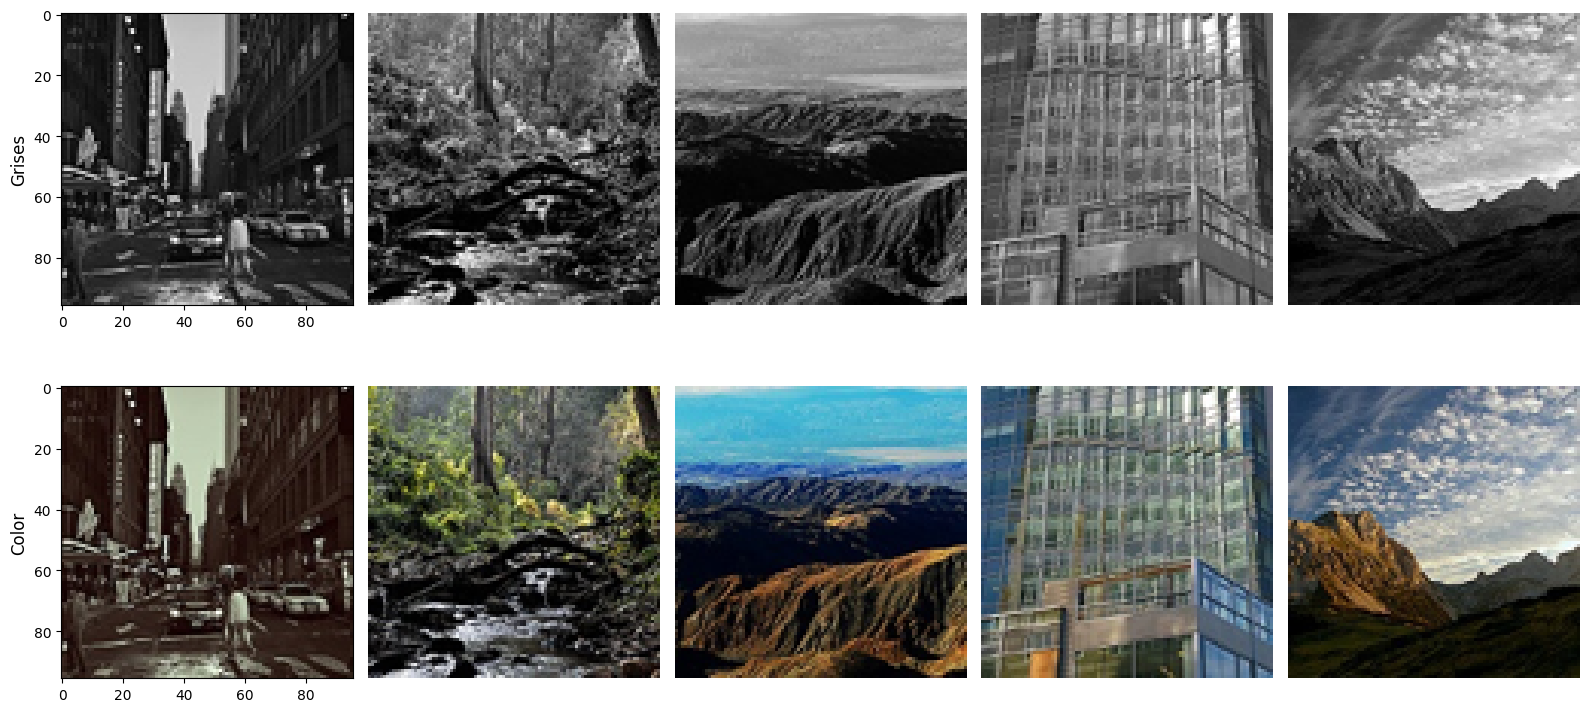

(96, 96, 3)

In [ ]:
# Definir una función para mostrar imágenes en dos filas
def plot_images(color_images, grayscale_images, num_images):

    fig, axes = plt.subplots(2, num_images, figsize=(16, 8))

    # Dibujar imágenes en color en la primera fila
    for i in range(num_images):
        axes[0, i].imshow(color_images[i])
        #axes[0, i].set_title('Color Image', color='green', fontsize=12)
        axes[0, i].axis('off')

    # Dibujar imágenes en escala de grises en la segunda fila
    for i in range(num_images):
        axes[1, i].imshow(grayscale_images[i], cmap='gray')
        #axes[1, i].set_title('Grayscale Image', color='black', fontsize=12)
        axes[1, i].axis('off')

    # Agregar títulos
    axes[0, 0].set_ylabel('Grises' , fontsize=12)
    axes[1, 0].set_ylabel('Color', fontsize=12)
    axes[0, 0].axis('on')
    axes[1, 0].axis('on')


    plt.tight_layout()
    plt.show()

plot_images(gray_img, color_img, 5)
gray_img[0].shape

**Separa en datos de entrenamiento y prueba**

Separa ambos grupos de imagenes en entrenamiento y prueba. Es importante que los indices

In [ ]:
NUM_IMGS = len(gray_img)
NUM_TRAIN = int(NUM_IMGS * 0.9)

train_gray_img = gray_img[:NUM_TRAIN]
train_color_img = color_img[:NUM_TRAIN]

test_gray_img = gray_img[NUM_TRAIN:]
test_color_img = color_img[NUM_TRAIN:]

# estructura para dar formato para procesar por la red
train_gray_img = np.reshape(train_gray_img, (-1, SIZE, SIZE, 3))
train_color_img = np.reshape(train_color_img, (-1, SIZE, SIZE, 3))
print('Shape de imagenes de entrenamiento:', train_color_img.shape)

test_gray_img = np.reshape(test_gray_img, (len(test_gray_img), SIZE, SIZE, 3))
test_color_img = np.reshape(test_color_img, (-1, SIZE, SIZE, 3))
print('Shape de imagenes de prueba.......:', test_color_img.shape)

Shape de imagenes de entrenamiento: (6416, 96, 96, 3)
Shape de imagenes de prueba.......: (713, 96, 96, 3)


**Construccion del modelo**

Construye el modelo utilizando capas convolucionales que reducen el tamaño de la imagen a través del stride e incrementan la cantidad de filtros hasta llegar al espacio de representación latente. Luego se realiza el proceso inverso agregando capas convolucionales que decrementan la cantidad de filtros y capas de Upsampling para ir recuperando el tamaño de la imagen al original.

In [ ]:
def crear_modelo(img_h, img_w, activ='relu'):

    # codificador
    inputs1 = layers.Input(shape=(img_h, img_w, 3,))
    encoder_output = layers.Conv2D(128, (3,3), activation=activ, padding='same', strides=2)(inputs1)
    encoder_output = layers.Conv2D(256, (3,3), activation=activ, padding='same', strides=2)(encoder_output)
    encoder_output = layers.Conv2D(512, (3,3), activation=activ, padding='same')(encoder_output)

    # decodificador
    decoder_output = layers.Conv2D(512, (3,3), activation=activ, padding='same')(encoder_output)
    decoder_output = layers.Conv2DTranspose(256, (3,3),padding = 'same', strides = 2)(decoder_output)
    decoder_output = layers.Conv2D(256, (3,3), activation=activ, padding='same')(decoder_output)
    decoder_output = layers.Conv2DTranspose(128, (3,3),padding = 'same', strides = 2)(decoder_output)
    decoder_output = layers.Conv2D(128, (3,3), activation=activ, padding='same')(decoder_output)
    decoder_output = layers.Conv2D(3, (3, 3), activation='tanh', padding='same')(decoder_output)

    model = models.Model(inputs=inputs1, outputs=decoder_output)

    return model

model = crear_modelo(SIZE, SIZE, activ='relu')

# Compilar y entrenar el modelo utilizando el generador de datos
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='mean_absolute_error')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 256)       295168    
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 512)       1180160   
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 512)       2359808   
                                                                 
 conv2d_transpose (Conv2DTr  (None, 48, 48, 256)       1179904   
 anspose)                                                        
                                                             

**Entrenamiento**

In [ ]:
model.fit(train_gray_img, train_color_img, epochs = 80, batch_size = 100, verbose = 1)

Epoch 1/80
65/65 [==============================] - 75s 717ms/step - loss: 0.3945 - acc: 0.3363
Epoch 2/80
65/65 [==============================] - 43s 655ms/step - loss: 0.0992 - acc: 0.4113
Epoch 3/80
65/65 [==============================] - 43s 664ms/step - loss: 0.0870 - acc: 0.4308
Epoch 4/80
65/65 [==============================] - 43s 661ms/step - loss: 0.0795 - acc: 0.4631
Epoch 5/80
65/65 [==============================] - 43s 663ms/step - loss: 0.0753 - acc: 0.4708
Epoch 6/80
65/65 [==============================] - 43s 662ms/step - loss: 0.0709 - acc: 0.4800
Epoch 7/80
65/65 [==============================] - 43s 662ms/step - loss: 0.0701 - acc: 0.4786
Epoch 8/80
65/65 [==============================] - 43s 663ms/step - loss: 0.0670 - acc: 0.4835
Epoch 9/80
65/65 [==============================] - 43s 663ms/step - loss: 0.0667 - acc: 0.4854
Epoch 10/80
65/65 [==============================] - 43s 665ms/step - loss: 0.0648 - acc: 0.4941
Epoch 11/80
65/65 [====================

**Evaluación con datos de prueba**

In [ ]:
model.evaluate(test_gray_img,test_color_img)

23/23 [==============================] - 5s 120ms/step - loss: 0.0498 - acc: 0.5628


[0.04980945959687233, 0.5627667903900146]

**Visualización de Resultados**

Muestra varias imagenes en escalas de grises con la versión de su imagen a color y la versión de la imagen coloreada

23/23 [==============================] - 2s 72ms/step


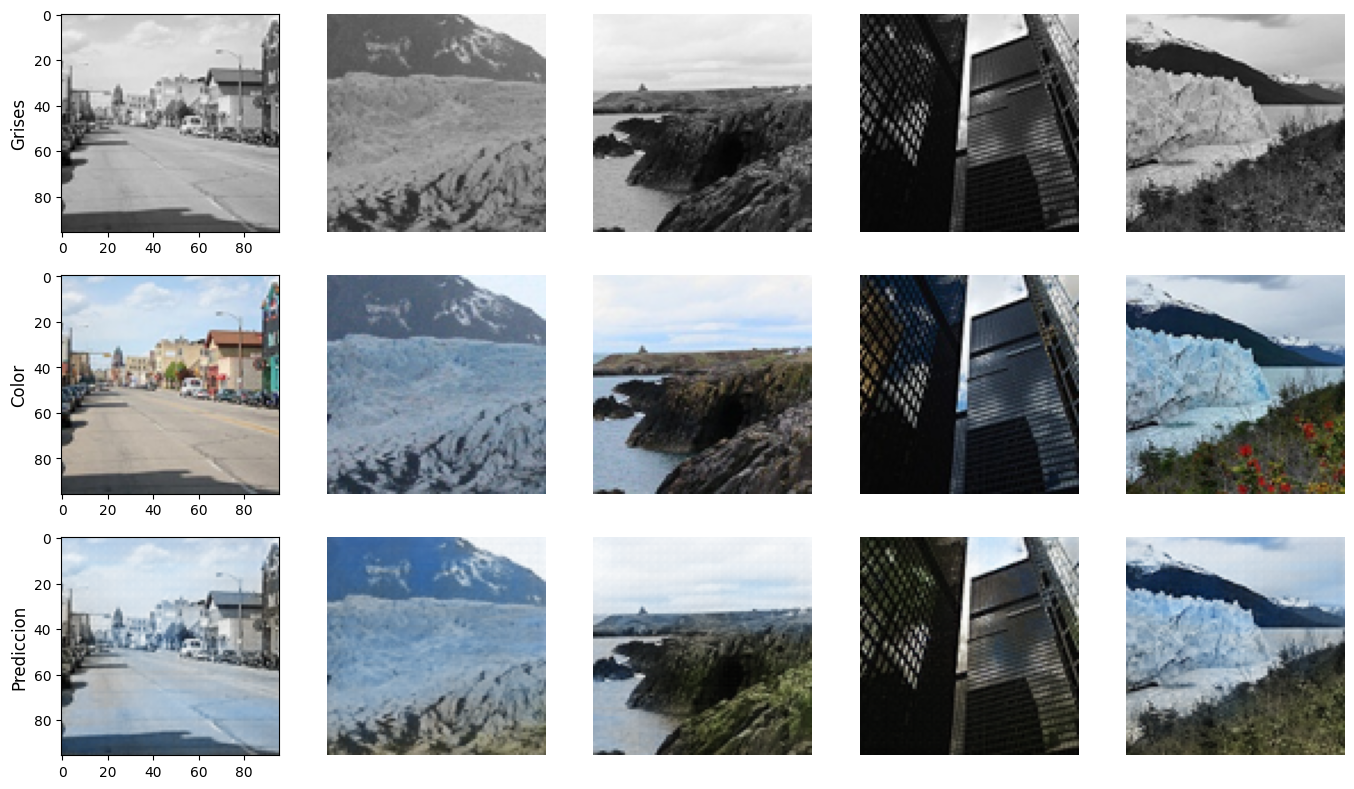

In [ ]:
# Definir una función para mostrar imágenes en dos filas
def plot_images(grayscale_img, color_img, predicted_img, ini_img, num_img):

    fig, axes = plt.subplots(3, num_img, figsize=(14, 8))

    # Dibujar imágenes en escala de grises en la segunda fila
    for i in range(num_img):
        axes[0, i].imshow(grayscale_img[ini_img+i], cmap='gray')

        axes[0, i].axis('off')

     # Dibujar imágenes en color en la primera fila
    for i in range(num_img):
        axes[1, i].imshow(color_img[ini_img+i])
        axes[1, i].axis('off')

    # Dibujar imágenes en color en la primera fila
    for i in range(num_img):
        axes[2, i].imshow(predicted_img[ini_img+i])
        axes[2, i].axis('off')

    # Agregar títulos
    axes[0, 0].set_ylabel('Grises' , fontsize=12)
    axes[1, 0].set_ylabel('Color', fontsize=12)
    axes[2, 0].set_ylabel('Prediccion', fontsize=12)
    axes[0, 0].axis('on')
    axes[1, 0].axis('on')
    axes[2, 0].axis('on')

    plt.tight_layout()
    plt.show()


ini_imgs = 6
num_imgs = 5

# obtiene imágenes coloreadas del dataset de prueba a partir de imagenes en escala de grises
predicted_img = model.predict(test_gray_img)

plot_images(test_gray_img, test_color_img, predicted_img, ini_imgs, num_imgs)
